In [1]:
# this notebook will demo the basic useage of langgraph

# it will first create llm instance which is connected to a locally host LLM
import multiprocessing

from langchain_community.chat_models import ChatLlamaCpp

local_model = "./models/Phi-3-medium-4k-instruct-Q4_K_M.gguf"

llm = ChatLlamaCpp(
    temperature=0.5,
    model_path=local_model,
    n_ctx=10000,
    n_gpu_layers=100000,
    n_batch=3000,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    max_tokens=2048,
    n_threads=multiprocessing.cpu_count() - 1,
    repeat_penalty=1.5,
    top_p=0.5,
    verbose=True,
)

llama_model_loader: loaded meta data with 30 key-value pairs and 243 tensors from ./models/Phi-3-medium-4k-instruct-Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = phi3
llama_model_loader: - kv   1:                               general.name str              = Phi3
llama_model_loader: - kv   2:                        phi3.context_length u32              = 4096
llama_model_loader: - kv   3:  phi3.rope.scaling.original_context_length u32              = 4096
llama_model_loader: - kv   4:                      phi3.embedding_length u32              = 5120
llama_model_loader: - kv   5:                   phi3.feed_forward_length u32              = 17920
llama_model_loader: - kv   6:                           phi3.block_count u32              = 40
llama_model_loader: - kv   7:                  phi3.attention.head_co

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    """
    Messages have the type "list". The `add_messages` function
    in the annotation defines how this state key should be updated
    (in this case, it appends messages to the list, rather than overwriting them)
    """

    messages: Annotated[list, add_messages]

# a state graph object defines the structure of our chatbot as a "state machine"
graph_builder = StateGraph(State)

In [3]:
# define a function that will be called whenever the "chatbot" node is used
# it takes the current state as input and returns the new state by invoking the LLM with the current state's messages
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

"""
The first argument is the unique node name
The second argument is the function or object that will be called whenever
the node is used.
"""
graph_builder.add_node("chatbot", chatbot)

# add start and end edge to the graph connecting the node chatbot
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

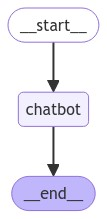

In [4]:
from helper import render_graph
render_graph(graph)

In [4]:
while True:
    # get user input
    user_input = input("User: ")
    # check for exit condition
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    # run the graph with the user input
    print ("User: ", user_input)
    for event in graph.stream({"messages": ("user", user_input)}):
        # output the chatbot's response
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User:  why does it rain on earth? can it happen on another planet?



llama_print_timings:        load time =     128.62 ms
llama_print_timings:      sample time =      50.46 ms /   215 runs   (    0.23 ms per token,  4261.14 tokens per second)
llama_print_timings: prompt eval time =     128.56 ms /    17 tokens (    7.56 ms per token,   132.23 tokens per second)
llama_print_timings:        eval time =    4594.84 ms /   214 runs   (   21.47 ms per token,    46.57 tokens per second)
llama_print_timings:       total time =    4869.01 ms /   231 tokens


Assistant:  Rain is a part of the Earth's water cycle, which involves evaporation from bodies like oceans and lakes into clouds. When these tiny droplets in cloud combine to become heavier than air currents that carry them upward they fall back down as rain or other forms such snow if it’ s cold enough at ground level
 	The possibility of rainfall on another planet depends largely upon the presence and state (solid, liquid)of water. For instance: Mars has polar ice caps made from frozen carbon dioxide which sublimates directly into gas during warmer seasons but doesn't rain like Earth does due to lack sufficient atmospheric pressure or temperature for sustained stable bodies of surface liquids
 	On the other hand, Saturn’s moon Titan has a dense atmosphere and liquid hydrocarbon lakes that experience methane rainfall. This is an example where another celestial body experiences precipitation but with different materials than Earth' s water-based rain system
Goodbye!


In [3]:
import os
from helper import get_api_key
from langchain_community.tools.tavily_search import TavilySearchResults

# set the TAVILY_API_KEY environment variable to the API key
os.environ["TAVILY_API_KEY"] = get_api_key(1)

# create a TavilySearchResults tool with a maximum of 2 results
searchtool = TavilySearchResults(max_results=2)
tools = [searchtool]
# invoke the tool
searchtool.invoke("How tall is the Eiffel Tower?")

[{'url': 'https://en.wikipedia.org/wiki/Eiffel_Tower',
  'content': 'Eiffel was similarly unworried, pointing out to a journalist that it was premature to judge the effect of the tower solely on the basis of the drawings, that the Champ de Mars was distant enough from the monuments mentioned in the protest for there to be little risk of the tower overwhelming them, and putting the aesthetic argument for the tower: "Do not the laws of natural forces always conform to the secret laws of harmony?"[17]\nSome of the protesters changed their minds when the tower was built; others remained unconvinced.[18] Guy de Maupassant supposedly ate lunch in the tower\'s restaurant every day because it was the one place in Paris where the tower was not visible.[19]\nBy 1918, it had become a symbol of Paris and of France after Guillaume Apollinaire wrote a nationalist poem in the shape of the tower (a calligram) to express his feelings about the war against Germany.[20] The most recent, devised in 2004 a

In [4]:
# we can now bind the tools to the LLM instance
llm_with_tools = llm.bind_tools(tools)

# start a new graph builder and add the new chatbot node
graph_builder_1 = StateGraph(State)

def chatbot_1(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder_1.add_node("chatbot", chatbot_1)


In [5]:
# build a basic tool node to demo tool calling
import json
from typing import Any
from langchain_core.messages import ToolMessage

class BasicToolNode:
    #A node that runs the tools requested in the last AI Message
    def __init__(self, tools):
        self.tools_by_name = {tool.name: tool for tool in tools}
    
    def __call__(self, inputs: dict):
        # get the last message from the inputs, if not raise an error
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No messages in inputs")
        outputs =[]
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call.tool_name].invoke(tool_call["args"])
            outputs.append(
                ToolMessage(
                    content = json.dumps(tool_result),
                    name = tool_call["name"],
                    tool_call_id = tool_call["id"]
                )  
            )
        return {"messages": outputs} 
    
# add the tools node to the graph
tool_node = BasicToolNode(tools = tools)
graph_builder_1.add_node("tools", tool_node)

In [6]:
# create conditional edge which will call the tools node if the last message contains tool calls
from typing import Literal

def route_tools(state: State,) -> Literal["tools", "__end__"]:
    # get message from state, check for different types of state
    if isinstance(state,list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError("No messages found in input state to tool_edge: {state}")
    
    # check if the message contains tool calls
    if hasattr(ai_message,"tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    
    return "__end__"

# add the conditional edge function to the graph
graph_builder_1.add_conditional_edges("chatbot", route_tools, {"tools": "tools", "__end__": "__end__"})

In [7]:

# add the rest of the edges
graph_builder_1.add_edge("tools", "chatbot")
graph_builder_1.add_edge(START, "chatbot")
# only use memory with the ToolNode
graph = graph_builder_1.compile()

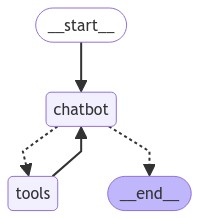

In [11]:
render_graph(graph)

In [8]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)


llama_print_timings:        load time =     137.11 ms
llama_print_timings:      sample time =      35.58 ms /   147 runs   (    0.24 ms per token,  4132.00 tokens per second)
llama_print_timings: prompt eval time =     137.05 ms /    14 tokens (    9.79 ms per token,   102.16 tokens per second)
llama_print_timings:        eval time =    3146.18 ms /   146 runs   (   21.55 ms per token,    46.41 tokens per second)
llama_print_timings:       total time =    3380.24 ms /   160 tokens


Assistant:  The height of Gustave's tower, also known as La Tour de Fer or more commonly referred to by its English name "The Iron Lady," has seen changes over time due primarily for maintenance and broadcasting purposes. Originally completed on March 31st during a year that marked the end-of an era in France - precisely one hundred years after Napoleon's coronation, it stood at approximately three times fifty meters tall when measured from its base to what was then considered as 'the tip.'
 However today The Iron Lady stands slightly taller due for broadcasting antennas. Including these additions the Eiffel Tower reaches a height of 324 metres (1063 feet).
Goodbye!
